In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# gpus = tf.config.list_physical_devices(device_type='GPU')
# if len(gpus)>0 :
#     print('use gpu')
#     tf.config.set_visible_devices(devices=gpus[0], device_type='GPU')

In [3]:
# data_dir = './data'
# train_bottle_dir = data_dir + '/train/塑料瓶/'
# train_chopsticks_dir = data_dir + '/train/一次性筷子/'

In [4]:
data_dir = './data/garbage_classification_1/'
battery_dir = data_dir + 'battery'
biological_dir = data_dir + 'biological'
brown_glass_dir = data_dir + 'brown-glass'
cardboard_dir = data_dir + 'cardboard'
clothes_dir = data_dir + 'clothes'
green_glass_dir = data_dir + 'green-glass'
metal_dir = data_dir + 'metal'
paper_dir = data_dir + 'paper'
plastic_dir = data_dir + 'plastic'
shoes_dir = data_dir + 'shoes'
trash_dir = data_dir + 'trash'
white_glass_dir = data_dir + 'white-glass'

dirs = [battery_dir,biological_dir,brown_glass_dir,
        cardboard_dir,clothes_dir,green_glass_dir,
        metal_dir,paper_dir,plastic_dir,
        shoes_dir,trash_dir,white_glass_dir]

classes = {'battery':0, 'biological':1, 'brown-glass':2,
           'cardboard':3, 'clothes':4, 'green-glass':5,
           'metal':6, 'paper':7, 'plastic':8,
           'shoes':9, 'trash':10, 'white-glass':11}

In [5]:
def load_data():
    images_name = []
    labels = []
    for file_dir in dirs:
        filename = tf.constant([file_dir + '/' + filename for filename in os.listdir(file_dir)])
        images_name = tf.concat([images_name,filename],axis=-1)
        labels_index = classes[file_dir.split('/')[-1]]
        labels = tf.concat([labels,tf.constant(labels_index,shape=filename.shape[0])],axis=-1)
    print("total:%d" %  images_name.shape[0])
    return images_name,labels

In [6]:
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)  # 读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
    return image_resized, label

In [7]:
train_filenames, train_labels = load_data()
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

total:15515


In [8]:
#设置超参数
num_epochs = 5
batch_size = 32
learning_rate = 0.02

train_dataset = train_dataset.shuffle(buffer_size=15000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
#训练
model = tf.keras.applications.DenseNet121(weights=None,classes=len(dirs))
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )

model.fit(train_dataset,epochs=num_epochs)

Epoch 1/5
1552/1552 [==============================] - 641s 341ms/step - loss: 1.7001 - sparse_categorical_accuracy: 0.4556
Epoch 2/5
1552/1552 [==============================] - 450s 285ms/step - loss: 1.2425 - sparse_categorical_accuracy: 0.5918
Epoch 3/5
1552/1552 [==============================] - 449s 284ms/step - loss: 1.0562 - sparse_categorical_accuracy: 0.6486
Epoch 4/5
1552/1552 [==============================] - 450s 284ms/step - loss: 0.9174 - sparse_categorical_accuracy: 0.6987
Epoch 5/5
1552/1552 [==============================] - 448s 283ms/step - loss: 0.7832 - sparse_categorical_accuracy: 0.7431


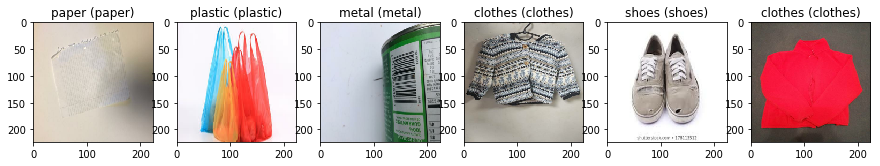

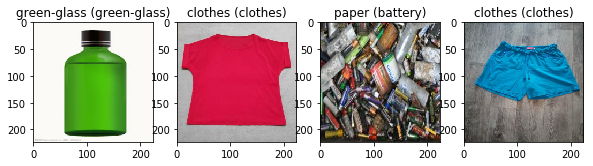

0.9


In [25]:
# 查看预测效果
for images, labels in train_dataset: 
    width,height = 6,batch_size//6+1
    acc=0
    for i in range(height):
        plt.figure(figsize=(15, 15))
        for j in range(width):
            plt.subplot(1,width,j+1)
            index = tf.math.argmax(model(tf.expand_dims(images[i*width+j],axis=0)),axis=1).numpy()
            if index ==labels[i*width+j].numpy():
                acc+=1
            for k,v in classes.items():
                if index==v:
                    kind_pre = k
                if labels[i*width+j].numpy() ==v:
                    kind_lab = k
            plt.title(kind_pre+' ('+kind_lab+')')
            plt.imshow(images[i*width+j].numpy())
            if i*width+j == batch_size-1:
                    break
        plt.show()
    print(acc/batch_size)
    break